## Stock clustering based on Volatility, Skewness and Kurtosis

In this notebook we will use the K-means clustering method for grouping stocks from the NDX100. We will divide the stocks into distinct groups based on volatility, skewness and kurtosis of stock returns.

In [1]:
# If you'd like to install packages that are not installed by default, uncomment the last two lines of this cell and replace  with a list of your packages.
# This will ensure your notebook has all the dependencies and works everywhere
import sys
!{sys.executable} -m pip install matplotlib numpy pandas scipy sklearn yfinance

Defaulting to user installation because normal site-packages is not writeable


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# import libraries
import matplotlib
import requests
#
import datetime as dt
import pandas as pd
import numpy as np
import yfinance as yf
#
from datetime import datetime
from math import sqrt
from matplotlib import pyplot as plt
from scipy.cluster.vq import kmeans,vq
from sklearn.cluster import KMeans

# https://www.pythonforfinance.net/2018/02/08/stock-clusters-using-k-means-algorithm-in-python/
# https://towardsdatascience.com/explain-ml-in-a-simple-way-k-means-clustering-e925d019743b
# https://www.askpython.com/python/examples/plot-k-means-clusters-python

In [4]:
# utils

#Function to generate the dataset
def dataset(ticker, days=4000):
    # Define time to download data
    today = datetime.today()
    initial = today - dt.timedelta(days=days)
    today = today.strftime('%Y-%m-%d')
    initial = initial.strftime('%Y-%m-%d')
    #Download data with YFINANCE
    df = yf.download(ticker, start=initial, end=today, progress=False)
    return df

# 0. Import NDX100 tickers

In [5]:
headers={"user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36"}
res=requests.get("https://api.nasdaq.com/api/quote/list-type/nasdaq100",headers=headers)
main_data=res.json()['data']['data']['rows']

symbols = []
for i in range(len(main_data)):
    print(main_data[i]['companyName'])
    symbols.append(main_data[i]['symbol'])
symbols.sort()

Costco Wholesale Corporation
Lucid Group, Inc.
Apple Inc.
Amgen Inc.
Comcast Corporation
Intel Corporation
KLA Corporation
PACCAR Inc.
Cintas Corporation
Paychex, Inc.
Lam Research Corporation
Autodesk, Inc.
Ross Stores, Inc.
Monster Beverage Corporation
Microsoft Corporation
Adobe Inc.
Fiserv, Inc.
Fastenal Company
Electronic Arts Inc.
Cisco Systems, Inc.
Regeneron Pharmaceuticals, Inc.
IDEXX Laboratories, Inc.
Vertex Pharmaceuticals Incorporated
Biogen Inc.
Old Dominion Freight Line, Inc.
QUALCOMM Incorporated
Gilead Sciences, Inc.
Synopsys, Inc.
Starbucks Corporation
Sirius XM Holdings Inc.
Intuit Inc.
Microchip Technology Incorporated
O'Reilly Automotive, Inc.
Dollar Tree, Inc.
ASML Holding N.V.
ANSYS, Inc.
Cognizant Technology Solutions Corporation
CoStar Group, Inc.
eBay Inc.
NVIDIA Corporation
Booking Holdings Inc.
Intuitive Surgical, Inc.
Marvell Technology, Inc.
Illumina, Inc.
Analog Devices, Inc.
American Electric Power Company, Inc.
Advanced Micro Devices, Inc.
Cadence Desig

In [6]:
symbols

['AAPL',
 'ABNB',
 'ADBE',
 'ADI',
 'ADP',
 'ADSK',
 'AEP',
 'ALGN',
 'AMAT',
 'AMD',
 'AMGN',
 'AMZN',
 'ANSS',
 'ASML',
 'ATVI',
 'AVGO',
 'AZN',
 'BIIB',
 'BKNG',
 'BKR',
 'CDNS',
 'CEG',
 'CHTR',
 'CMCSA',
 'COST',
 'CPRT',
 'CRWD',
 'CSCO',
 'CSGP',
 'CSX',
 'CTAS',
 'CTSH',
 'DDOG',
 'DLTR',
 'DXCM',
 'EA',
 'EBAY',
 'ENPH',
 'EXC',
 'FANG',
 'FAST',
 'FISV',
 'FTNT',
 'GFS',
 'GILD',
 'GOOG',
 'GOOGL',
 'HON',
 'IDXX',
 'ILMN',
 'INTC',
 'INTU',
 'ISRG',
 'JD',
 'KDP',
 'KHC',
 'KLAC',
 'LCID',
 'LRCX',
 'LULU',
 'MAR',
 'MCHP',
 'MDLZ',
 'MELI',
 'META',
 'MNST',
 'MRNA',
 'MRVL',
 'MSFT',
 'MU',
 'NFLX',
 'NVDA',
 'NXPI',
 'ODFL',
 'ORLY',
 'PANW',
 'PAYX',
 'PCAR',
 'PDD',
 'PEP',
 'PYPL',
 'QCOM',
 'REGN',
 'RIVN',
 'ROST',
 'SBUX',
 'SGEN',
 'SIRI',
 'SNPS',
 'TEAM',
 'TMUS',
 'TSLA',
 'TXN',
 'VRSK',
 'VRTX',
 'WBA',
 'WBD',
 'WDAY',
 'XEL',
 'ZM',
 'ZS']

In [7]:
# retrieve time series for all stocks
df = pd.DataFrame()
for symbol in symbols:
    if df.empty:
        df=dataset(symbol)['Open']
        df.name = symbol
    else:
        df2 = dataset(symbol)['Open']
        df2.name = symbol
        df = pd.concat([df,df2], axis=1)

In [8]:
df.head()

,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,...,TSLA,TXN,VRSK,VRTX,WBA,WBD,WDAY,XEL,ZM,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-12,15.081429,NaN,29.430000,37.000000,48.007023,32.330002,41.330002,24.070000,11.81,5.83,...,1.898667,30.790001,40.340000,37.299999,34.169998,22.003065,NaN,27.180000,NaN,NaN
2012-01-13,14.989286,NaN,29.110001,37.049999,47.919228,32.000000,41.060001,24.320000,11.75,5.76,...,1.893333,31.110001,39.700001,36.860001,33.180000,22.089933,NaN,26.160000,NaN,NaN
2012-01-17,15.150000,NaN,29.170000,36.930000,48.287971,32.500000,41.580002,24.250000,11.80,5.77,...,1.774667,31.340000,40.160000,36.720001,32.930000,22.483393,NaN,26.889999,NaN,NaN
2012-01-18,15.248571,NaN,29.270000,38.290001,48.972782,32.130001,41.500000,24.910000,11.89,5.73,...,1.779333,31.969999,39.320000,36.599998,33.189999,22.294329,NaN,26.740000,NaN,NaN
2012-01-19,15.362500,NaN,29.910000,39.169998,49.745392,34.430000,41.549999,24.719999,12.19,6.02,...,1.812667,33.439999,39.910000,37.500000,33.310001,22.478283,NaN,26.799999,NaN,NaN


In [9]:
# returns
returns = df.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = df.pct_change().std() * sqrt(252)
returns['Skewness'] = df.pct_change().skew()
returns['Kurtosis'] = df.pct_change().kurt()
returns.pop('Returns')
returns

,Volatility,Skewness,Kurtosis
AAPL,0.302964,0.008594,6.184388
ABNB,0.584408,0.137197,0.951603
ADBE,0.298337,-0.254617,5.130230
ADI,0.281757,0.104747,3.297693
ADP,0.222288,-0.027782,6.061255
...,...,...,...
WBD,0.386437,-0.642386,7.559486
WDAY,0.392267,-0.152210,4.406791
XEL,0.190238,-0.800833,9.769267
ZM,0.691880,1.314233,12.741244


# 1. Plot volatility, skewness and kurtosis

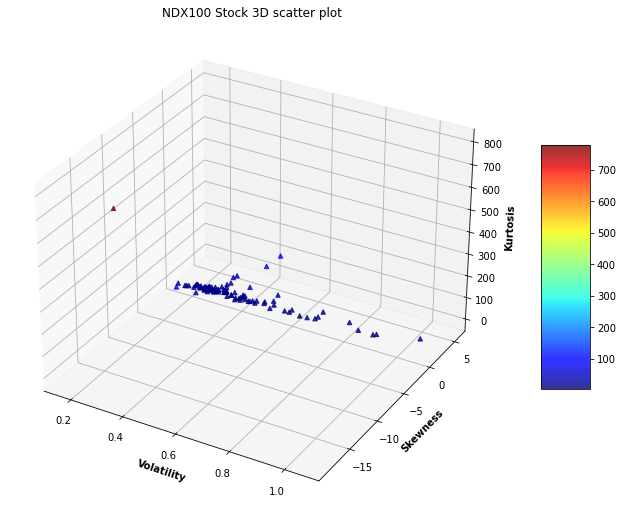

In [10]:
# Creating dataset
z = returns['Kurtosis'].values
x = returns['Volatility'].values
y = returns['Skewness'].values

# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
# Add x, y gridlines
ax.grid(visible = True, color ='grey', linestyle ='-.',linewidth = 0.3, alpha=0.2)
# Creating color map
my_cmap = plt.get_cmap('jet')
# Creating plot
sctt = ax.scatter3D(x, y, z, alpha = 0.8, c = (x + y + z), cmap = my_cmap, marker ='^')
plt.title("NDX100 Stock 3D scatter plot")
ax.set_xlabel('Volatility', fontweight ='bold')
ax.set_ylabel('Skewness', fontweight ='bold')
ax.set_zlabel('Kurtosis', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
# show plot
plt.show()

We observe that there is an outlier in terms of Kurtosis.

Stocks differ in their volatility.

Most stocks have similar skewness, but a few of them cluster with higher values.

In [11]:
returns.loc[returns['Kurtosis']>500]

,Volatility,Skewness,Kurtosis
KDP,0.346549,-18.659548,797.037531


The outlier in terms of Kurtosis happens to be KDP ticker.

We will drop it from our analysis.

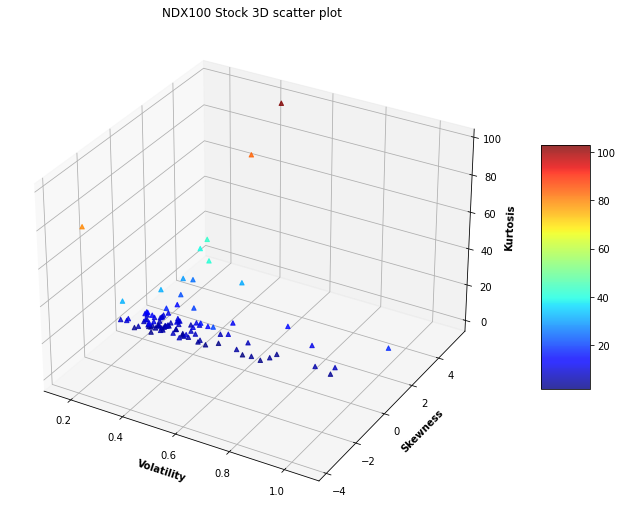

In [12]:
df.pop('KDP')
# returns
returns = df.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = df.pct_change().std() * sqrt(252)
returns['Skewness'] = df.pct_change().skew()
returns['Kurtosis'] = df.pct_change().kurt()
returns.pop('Returns')
# Creating dataset
z = returns['Kurtosis'].values
x = returns['Volatility'].values
y = returns['Skewness'].values

# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
# Add x, y gridlines
ax.grid(visible = True, color ='grey', linestyle ='-.',linewidth = 0.3, alpha=0.2)
# Creating color map
my_cmap = plt.get_cmap('jet')
# Creating plot
sctt = ax.scatter3D(x, y, z, alpha = 0.8, c = (x + y + z), cmap = my_cmap, marker ='^')
plt.title("NDX100 Stock 3D scatter plot")
ax.set_xlabel('Volatility', fontweight ='bold')
ax.set_ylabel('Skewness', fontweight ='bold')
ax.set_zlabel('Kurtosis', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
# show plot
plt.show()

Now we observe a smoother 3D graph. 

Some stocks cluster with higher level of kurtosis.

Others have higher volatility.

Others have higher skewness.

# 2. Plot the Elbow Curve

Our first decision is to choose how many clusters do we actually want to separate the data into. Rather than make some arbitrary decision we can use an “Elbow Curve” to highlight the relationship between how many clusters we choose, and the Sum of Squared Errors (SSE) resulting from using that number of clusters.

We then plot this relationship to help us identify the optimal number of clusters to use – we would prefer a lower number of clusters, but also would prefer the SSE to be lower – so this trade off needs to be taken into account.

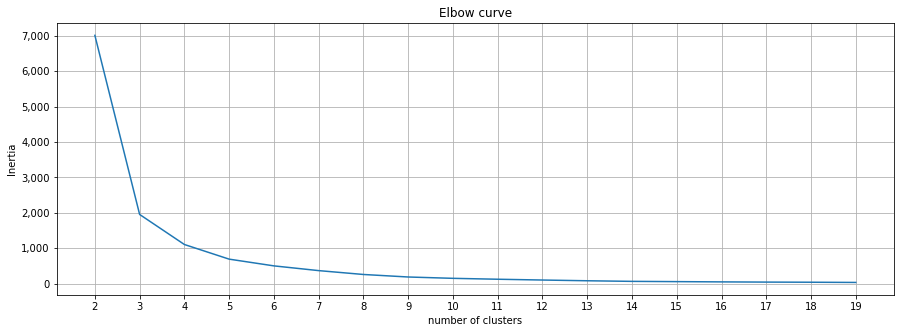

In [13]:
data = np.asarray([np.asarray(returns['Volatility']),np.asarray(returns['Skewness']),np.asarray(returns['Kurtosis'])]).T
X = data
distorsions = []
for k in range(2, 20):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.xticks(np.arange(2,20))
plt.xlabel('number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve')
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}"))
plt.savefig('Elbow_curve.png')
plt.show()
plt.close()

So we can see that once the number of clusters reaches 4 (on the bottom axis), the reduction in the objective function (SSE, Cluster Inertia) begins to slow down for each increase in cluster number. 

This would lead us to believe that the optimal number of clusters for this exercise lies around the 4 mark.

# 3. Clustering model

In [14]:
# computing K-Means with K = 4 (4 clusters)
k = 4
centroids,_ = kmeans(data,4)
# assign each sample to a cluster
labels,_ = vq(data,centroids)
labels

array([3, 3, 3, 3, 3, 0, 0, 0, 3, 3, 3, 0, 3, 3, 2, 3, 0, 1, 0, 0, 3, 3,
       3, 3, 3, 0, 3, 0, 2, 0, 0, 0, 3, 0, 0, 3, 3, 3, 3, 2, 3, 3, 0, 3,
       0, 0, 0, 0, 3, 2, 0, 3, 0, 0, 2, 0, 0, 3, 0, 2, 3, 1, 3, 0, 2, 3,
       3, 3, 3, 2, 3, 0, 3, 0, 3, 0, 3, 0, 0, 3, 2, 3, 3, 0, 0, 3, 3, 3,
       0, 2, 3, 3, 3, 1, 0, 0, 3, 0, 0, 3])

# 4. Plot the clusters

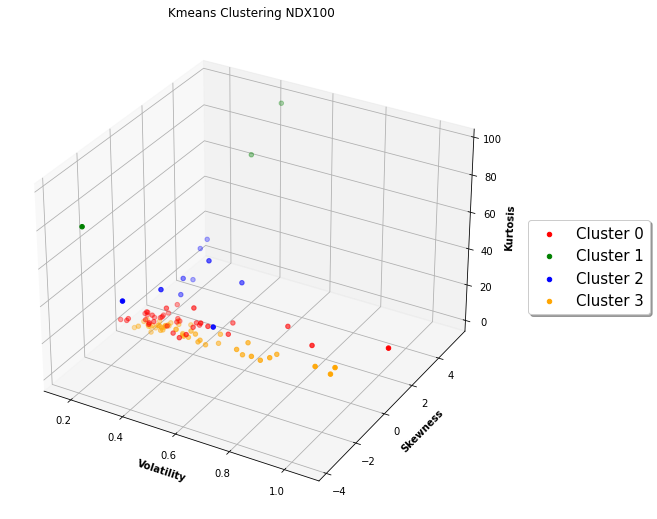

In [15]:
returns['labels']=labels
#filter rows of original data
filtered = {}
for i in range(k):
    filtered[i] = returns.loc[returns['labels'] == i]
    
colours = ['red','green','blue','orange','cyan','yellow','brown']
fig = plt.figure(figsize = (16, 9))
kplot = plt.axes(projection='3d')
# Data for three-dimensional scattered points
for i in range(k):
    kplot.scatter3D(filtered[i]['Volatility'], filtered[i]['Skewness'], filtered[i]['Kurtosis'], c=colours[i], label = f'Cluster {i}')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fancybox=True, shadow=True, fontsize=15)
plt.title("Kmeans Clustering NDX100")
kplot.set_xlabel('Volatility', fontweight ='bold')
kplot.set_ylabel('Skewness', fontweight ='bold')
kplot.set_zlabel('Kurtosis', fontweight ='bold')
plt.show()

# 5. Plot the time series of clustered stocks

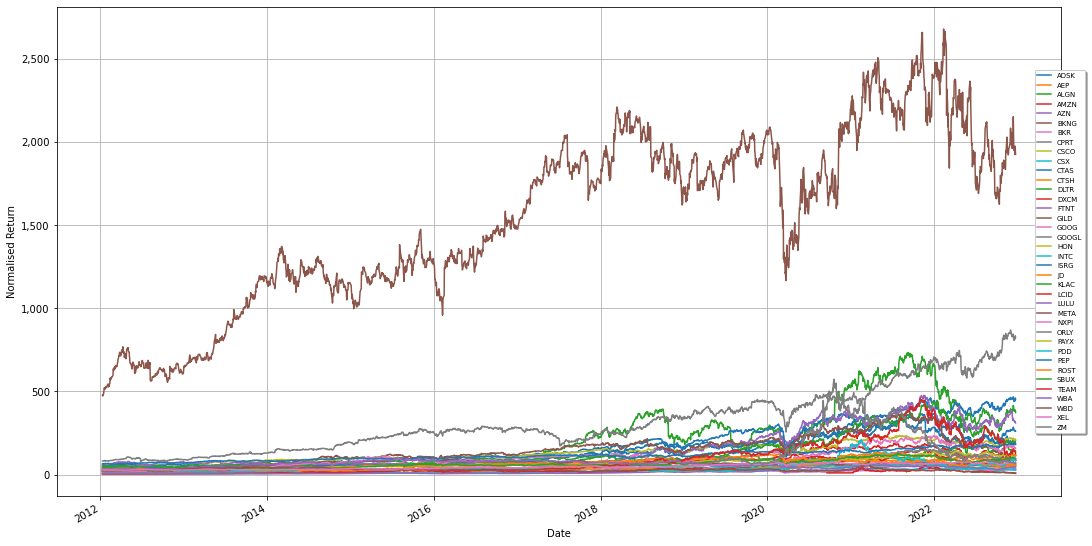

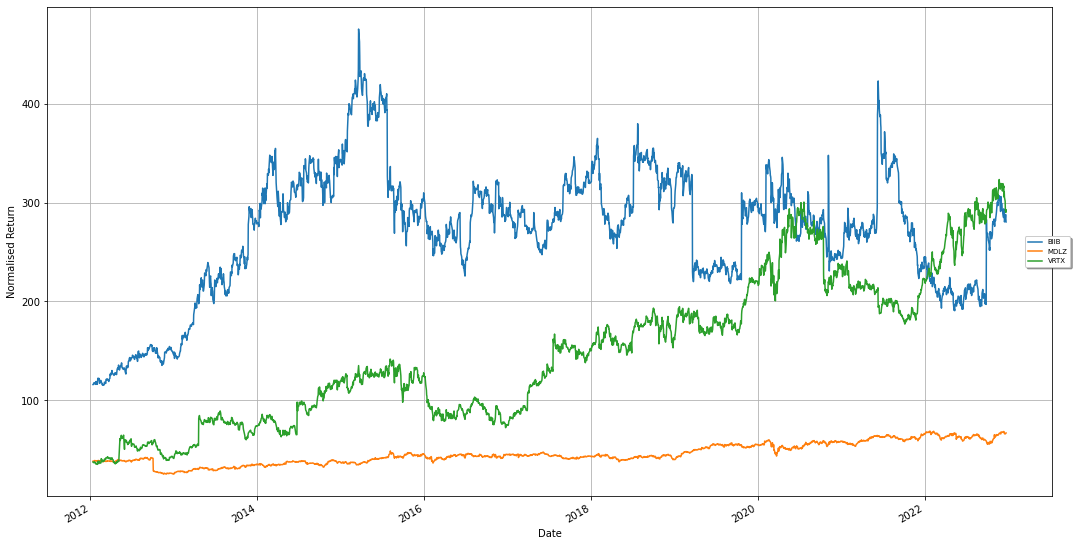

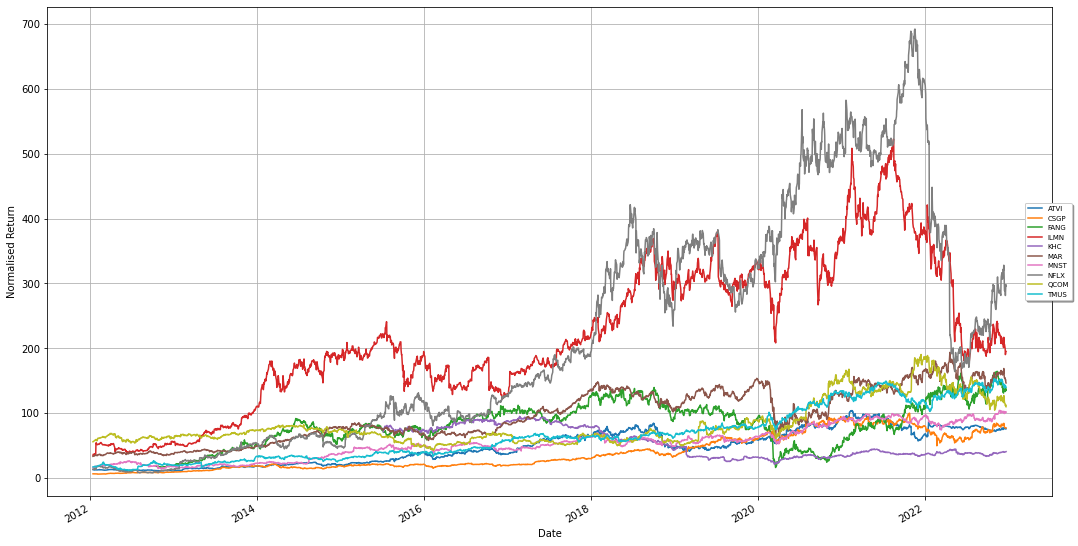

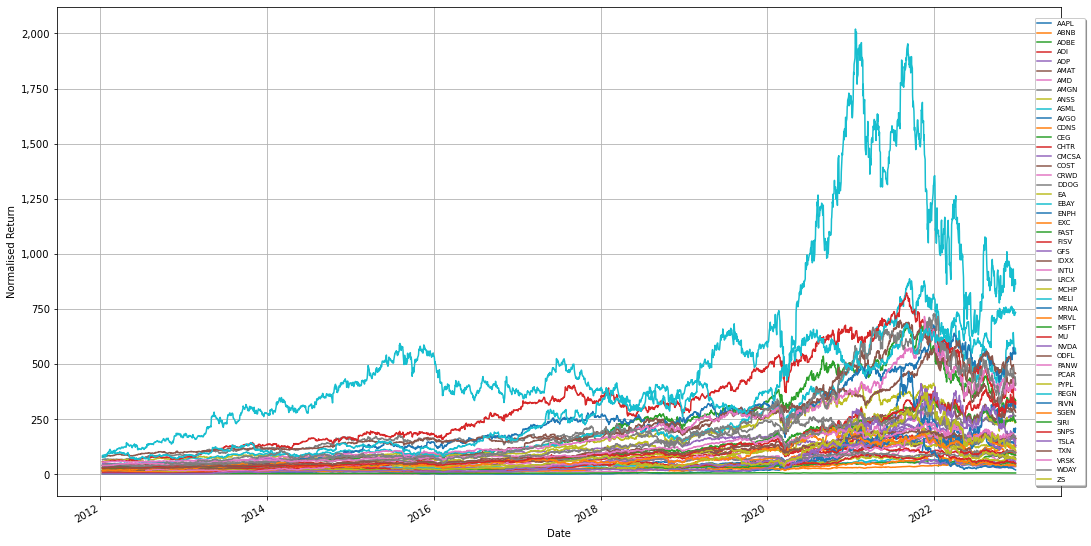

In [16]:
df_cluster = pd.DataFrame(list(zip(df.columns, labels)), columns=['symbol', 'cluster'])
for k in set(labels):
    cluster = df_cluster.loc[df_cluster['cluster']==k]
    stocks = cluster['symbol']
    stocks = df[stocks]
    stocks.plot(y=stocks.columns,figsize=(18, 10))
    # plt.tight_layout()
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(0.97, 0.5), fancybox=True, shadow=True, fontsize=7)
    plt.ylabel('Normalised Return')
    plt.xlabel('Date')
    plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}"))
    plt.savefig(f'cluster_{k}.png')
    plt.show()
    plt.close()

As it is typical with clustering you are always going to get some pretty bad random looking ones.

All in all, I found the 3D clustering method very useful as it saved me quite a bit of time to get a quick working prototype up and running.